In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import evaluate_heatmaps as e
import pickle
import agent_utils
import os
from importlib import reload

## Define Colormap

In [3]:
cmap_name = "winter"

# Define transparant to color cmap
ncolors = 256
color_array = plt.get_cmap(cmap_name)(range(ncolors))

color_array[:, -1] = np.linspace(0.0, 1.0, ncolors)

map_object = LinearSegmentedColormap.from_list(name="{}_alpha".format(cmap_name), colors=color_array)

def is_colormap_registered(cmap_name):
    try:
        plt.get_cmap(cmap_name)
        return True
    except ValueError:
        return False

if not is_colormap_registered(cmap_name + "_alpha"):
    matplotlib.colormaps.register(cmap=map_object)

## Heatmap creation and visualization

In [7]:
def create_human_heatmap(df, tr_num, cut=None):
    df_trial = df[df["trial"] == tr_num]
    if cut is not None:
        df_trial = df_trial[df_trial["t"] > cut]

    eye_data_arr = df_trial[["x", "y"]].to_numpy()

    hm = e.make_kde(eye_data_arr, 1)

    return hm

def visualize_heatmap(hm, trial_num, ax=None, condition="vision", cmap="winter_alpha", axis=False, grain="fine"):

    if condition == "occluded":
        folder = "occluded"
    else:
        folder = "final"

    if trial_num == "center" or trial_num == "holes":
        img = plt.imread("../../../figures/stimuli/inference/misc/empty_box.png")
    else:
        img = plt.imread(f"../../../figures/stimuli/inference/{folder}/world_{trial_num}.png")
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(img)
    
    if grain == "fine":
        x = np.arange(0, 601)
        y = np.arange(0, 501)
    elif grain == "coarse":
        x = np.arange(10, 610, 20)
        y = np.arange(10, 510, 20)

    if cmap == "viridis":
        ax.contourf(x, y, hm, cmap=cmap, alpha=0.3)
    else:
        ax.contourf(x, y, hm, cmap=cmap)
    
    
    if not axis:
        # ax.axis("off")
        ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    return ax

### Center

<Axes: >

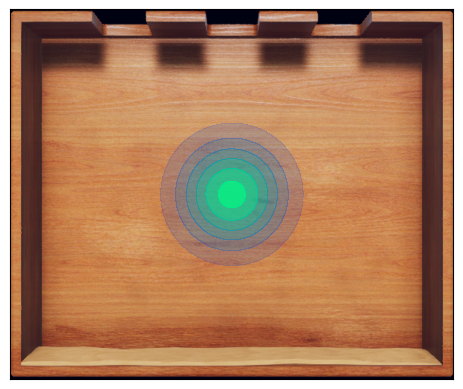

In [80]:
center_point = [300, 250]
center_hm = e.make_kde(np.array([center_point]), 1)
visualize_heatmap(center_hm, "center")

In [81]:
with open("heatmaps/center.pickle", "wb") as f:
    pickle.dump(center_hm, f)

### Holes

In [ ]:
world, _, _ = agent_utils.get_world(1)
hole_positions = np.array(world["hole_positions_unity"])
hole_positions

array([[151.22933545, 466.95793454],
       [300.        , 466.95793454],
       [448.77066455, 466.95793454]])

<Axes: >

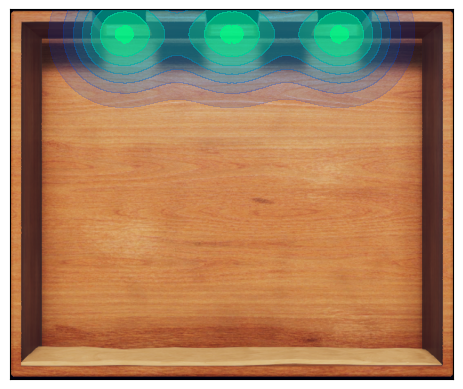

In [71]:
holes_hm = e.make_kde(hole_positions, 1)
visualize_heatmap(holes_hm, "holes")

In [82]:
with open("heatmaps/holes.pickle", "wb") as f:
    pickle.dump(holes_hm, f)

### Obstacles

In [89]:
world_nums = sorted([int(file[6:-5]) for file in os.listdir("stimuli/ground_truth")])

<Axes: >

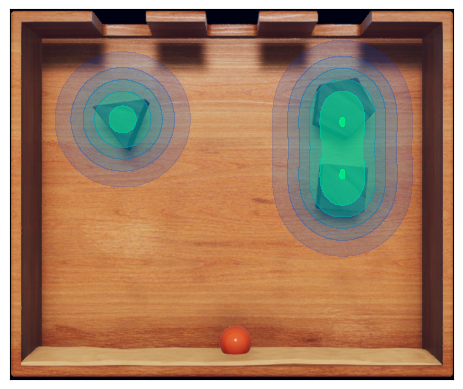

In [92]:
world, _, _ = agent_utils.get_world(1)
obstacle_positions = np.array(world["obstacle_positions_unity"])

obs_hm = e.make_kde(obstacle_positions, 1)
visualize_heatmap(obs_hm, 1)

In [93]:
for world_num in world_nums:
    world, _, _ = agent_utils.get_world(world_num)
    obstacle_positions = np.array(world["obstacle_positions_unity"])
    obs_hm = e.make_kde(obstacle_positions, 1)

    with open(f"heatmaps/obs_trial_{world_num}.pickle", "wb") as f:
        pickle.dump(obs_hm, f)

### Ball

<Axes: >

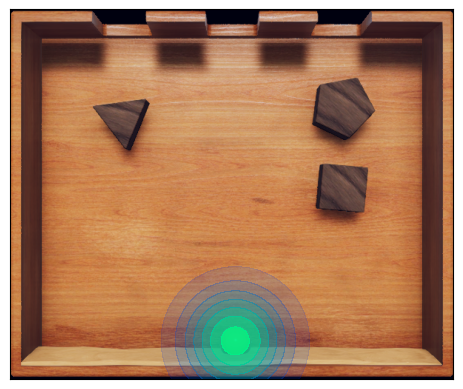

In [100]:
world, _, _ = agent_utils.get_world(1)
ball_position = np.array([[world["ball_final_position_unity"]["x"], world["ball_final_position_unity"]["y"]]])

ball_hm = e.make_kde(ball_position, 1)
visualize_heatmap(ball_hm, 1)

In [101]:
for world_num in world_nums:
    world, _, _ = agent_utils.get_world(world_num)
    ball_position = np.array([[world["ball_final_position_unity"]["x"], world["ball_final_position_unity"]["y"]]])
    ball_hm = e.make_kde(ball_position, 1)

    with open(f"heatmaps/ball_trial_{world_num}.pickle", "wb") as f:
        pickle.dump(ball_hm, f)

## Human heatmap cleaning and saving

In [102]:
def center_distance(df):
    df["distance"] = np.sqrt((df["x"] - 300)**2 + (df["y"] - 250)**2)
    df["t_bin"] = df["t"].floordiv(100)
    df_bin_agg = df.groupby(["t_bin"])["distance"].agg(["mean"])

    return df_bin_agg

def plot_center_distance(df_agg, nbins, condition, ax):

    if ax is None:
        _, ax = plt.subplots()

    ax.plot(df_agg.index[:nbins], df_agg.values[:nbins])
    ax.scatter(df_agg.index[:nbins], df_agg.values[:nbins])

    time_bins = [f"{i*100}-{(i+1)*100}" for i in range(nbins)]

    ax.set_title(condition)

    ax.set_xlabel("Time (ms)")
    ax.set_xticks(df_agg.index[:nbins])
    ax.set_xticklabels(time_bins, rotation=45)

    ax.set_ylabel("Distance to center (px)")
    ax.set_ylim(bottom=0)

In [106]:
df_vision = e.load_data(condition="vision")
df_audio = e.load_data(condition="audio")
df_occluded = e.load_data(condition="occluded")

In [ ]:
df_vision_bin_agg = center_distance(df_vision)
df_audio_bin_agg = center_distance(df_audio)
df_occluded_bin_agg = center_distance(df_occluded)

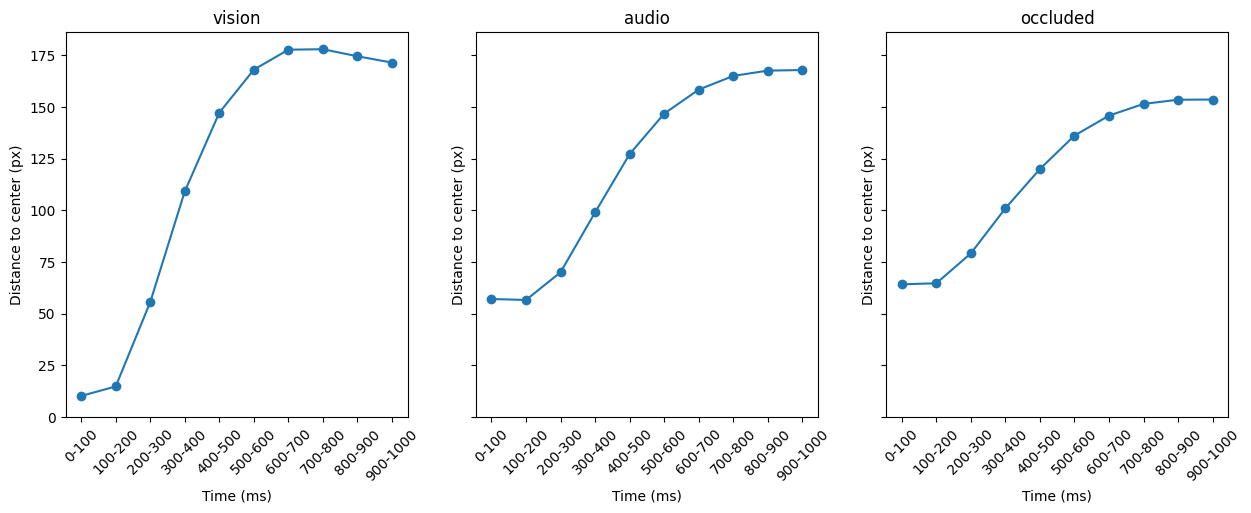

In [109]:
_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i,cond,df in [(0, "vision", df_vision_bin_agg), (1, "audio", df_audio_bin_agg), (2, "occluded", df_occluded_bin_agg)]:
    plot_center_distance(df, 10, cond, axes[i])

In [110]:
# set cut point at 300 ms
cut = 300
for condition, df in [("vision", df_vision), ("audio", df_audio), ("occluded", df_occluded)]:
    print("Condition", condition)
    for tr_num in world_nums:
        print("Trial", tr_num)
        hm = create_human_heatmap(df, tr_num, cut=cut)
        with open(f"heatmaps/human_trial_{condition}_test_{tr_num}_cut_{cut}_rt_cleaned.pickle", "wb") as f:
            pickle.dump(hm, f)
    print()

Condition vision
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 30
Trial 31
Trial 32
Trial 33
Trial 34
Trial 35
Trial 36
Trial 37
Trial 38
Trial 39
Trial 40
Trial 41
Trial 42
Trial 43
Trial 44
Trial 45
Trial 46
Trial 47
Trial 48
Trial 49
Trial 50
Trial 51
Trial 52
Trial 53
Trial 54
Trial 55
Trial 56
Trial 57
Trial 58
Trial 59
Trial 60
Trial 61
Trial 62
Trial 63
Trial 64
Trial 65
Trial 66
Trial 67
Trial 68
Trial 69
Trial 70
Trial 71
Trial 72
Trial 73
Trial 74
Trial 75
Trial 76
Trial 77
Trial 78
Trial 79
Trial 80
Trial 81
Trial 82
Trial 84
Trial 85
Trial 86
Trial 90
Trial 91
Trial 93
Trial 94
Trial 97
Trial 98
Trial 99
Trial 100
Trial 102
Trial 103
Trial 106
Trial 107
Trial 109
Trial 111
Trial 112
Trial 113
Trial 114
Trial 115
Trial 118
Trial 121
Trial 122
Trial 123
Trial 126
Tria